# Introduction and goals

In [16]:
# generic imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

In [17]:
%matplotlib inline
sns.set(palette='pastel')

The author of RF proposes two measures for feature ranking, the variable importance (VI) and Gini importance (GI). Sklearn random forest uses Gini index. Which we will explore in the following section

# Simulated data
The first batch of tests are done starting from a set of simulated data.
Lets create 6 variants of datasets:
* n=100, p=15 of which 5 informative
* n=100, p=50 of which 5 informative and 5 not informative
* n=100, p=300 of which 5 informative and 5 not informative
* n=1000, p=15 of which 5 informative
* n=1000, p=50 of which 5 informative and 5 not informative
* n=1000, p=300 of which 5 informative and 5 not informative

Lets first create the helper function that will generate the simulated data via `make_classification`, fit a random forest classifier and plot the data.

In [20]:
def rf_test(n_trees, n_samples, row_trees=False, feat = [10,200,500]):
    # feat = nr of features
    # number of redundant features
    rfeat=[0,10,10]

    # cycle through the number of trees, samples and features
    for k, t in enumerate(n_trees):
        for j, n in enumerate(n_samples):
            for i in range(0,len(feat)):
                # create and fit the rf classificator
                X, y = make_classification(n_samples=n, n_features=feat[i], n_informative=6, n_redundant=rfeat[i], random_state=0, shuffle=False)
                rf = RandomForestClassifier(n_estimators=t, n_jobs=-1, oob_score=False, random_state=0)
                rf.fit(X, y)
                # name of the features
                col = ['f'+str(i) for i in range(0,feat[i])]
                # retrieve the values of each feature importance of all the trees
                feat_importance = [t.feature_importances_ for t in rf.estimators_]
                df = pd.DataFrame(columns=col, data=feat_importance)
                # limit the max nr of columns to show in the plot
                maxcols=min(df.shape[1], 25)
                
                # plot
                row = k if row_trees else j
                sns.boxplot(data=df.iloc[:, :maxcols], ax=axis[row][i])
                plt.text(0.6, 0.8,'feat={}\nredundant feat={}'.format(feat[i], rfeat[i]), bbox=dict(facecolor='white', alpha=0.8), transform = axis[row][i].transAxes)

Just as an example lets explore the correlation matrix of the features of 2 simulated datasets with respectively 0 and 10 redundant features. The plots show this correlation very clearly.

Text(0.5,1,'6 informative feat - 10 redundant - 4 uncorrelated')

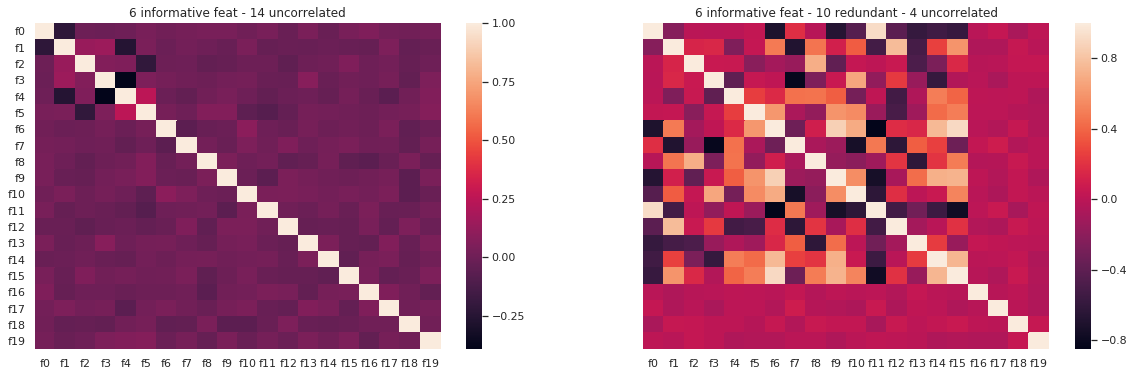

In [46]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=6, n_redundant=0, random_state=0, shuffle=False)
Xr, yr = make_classification(n_samples=1000, n_features=20, n_informative=6, n_redundant=10, random_state=0, shuffle=False)

col = ['f'+str(i) for i in range(0,20)]
df = pd.DataFrame(columns=col, data=X)
df_redundant = pd.DataFrame(columns=col, data=Xr)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 6))
sns.heatmap(df.corr(), ax=ax1)
ax1.set_title('6 informative feat - 14 uncorrelated')
sns.heatmap(df_redundant.corr(), ax=ax2)
ax2.set_title('6 informative feat - 10 redundant - 4 uncorrelated')

As a first test lets try a setup where the number of trees is kept fixed to 10, while the number of samples and the number of features is changed.

In the following examples only 6 features are informative.

The first column has 10 features and none of them are redundant (redundant features are created as linear combination of the informative ones). The second column has 200 features of which 10 are redundant while the last column has 500 features of which 10 are redundant.

The first row shows represent a dataset with 1000 samples, the second row instead has 10000 samples.

So overall the most difficult task is represented by the top right plot, where the number of features is very high, although not bigger than the number of samples.

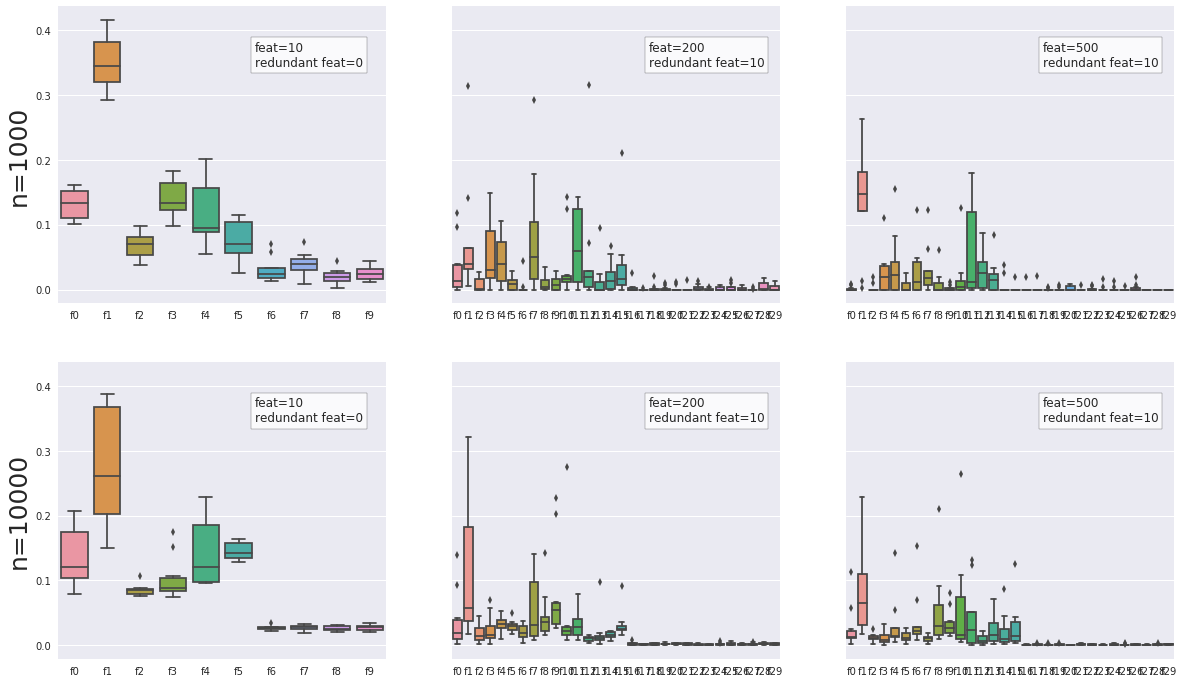

In [11]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, sharey=True, figsize=(20, 12))
axis = [[ax1, ax2, ax3], [ax4, ax5, ax6]]
n_samples=[1000, 10000]
n_trees=[10]

rf_test(n_trees, n_samples)
for i,n in enumerate(n_samples):
    axis[i][0].set_ylabel('n={}'.format(n), rotation=90, size=25)

Analyzing the above plots it is clear how in the first column, which represent the easiest task where there are no redundant features and the number of features is very small compared to the number of samples, the feature importance is able to detect very easily the 6 informative features. This is especially evident in the dataset with 10000 samples.

As the number of features increases this approach is able to detect the non-informative features which have very low variance and mean value, but it's not able to distinguish between the informative and redundant features.

Overall having a bigger sample size helps to decrease the variance of the feature importance values among the trees, as it was expected.

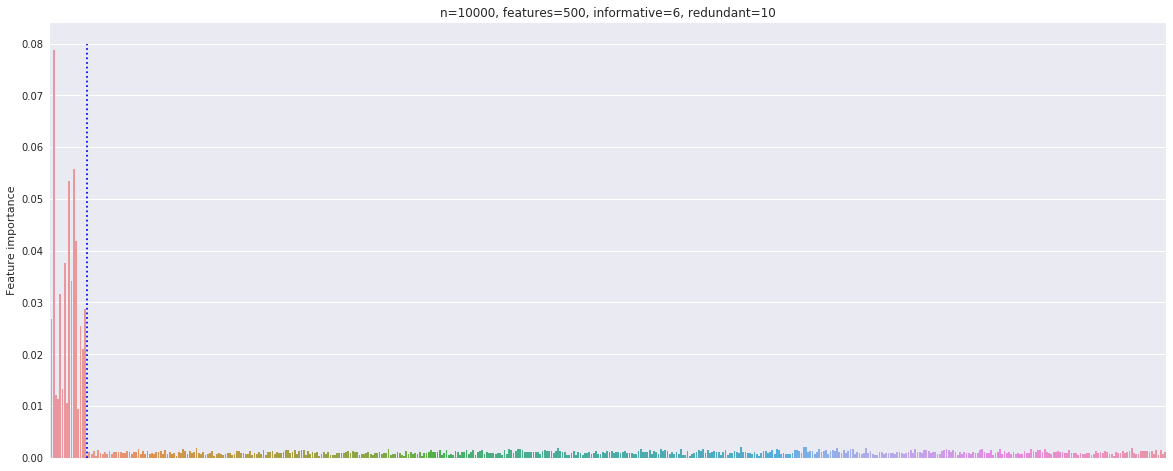

In [60]:
# reproduce the bottom right example of the previous grid of plots
X, y = make_classification(n_samples=10000, n_features=500, n_informative=6, n_redundant=10, random_state=0, shuffle=False)
rf = RandomForestClassifier(n_estimators=10, n_jobs=-1, oob_score=False, random_state=0)
rf.fit(X, y)

col = ['f'+str(i) for i in range(0,500)]
fig, ax = plt.subplots(1,1, figsize=(20, 8))
sns.barplot(x=col, y=rf.feature_importances_, ax=ax)
ax.xaxis.set_ticklabels([])
ax.set_ylabel('Feature importance')
ax.set_title('n=10000, features=500, informative=6, redundant=10')
# plot 16 features separator
ax.vlines(x=16, ymin=0.0, ymax=0.08, color='b', linestyles='dotted')

Since in the previous plots only the first 25 features where shown, the above plot shows the value of the feature importances referred to all the 500 features averaged among the 10 trees of the random forest. As it was expected, the first 16 features have significantly higher value compared to all the other non-informative features.

Lets try to follow the same procedure as above, but keeping fixed the number of samples to 10000 and varying the number of trees of the random forest classifier.

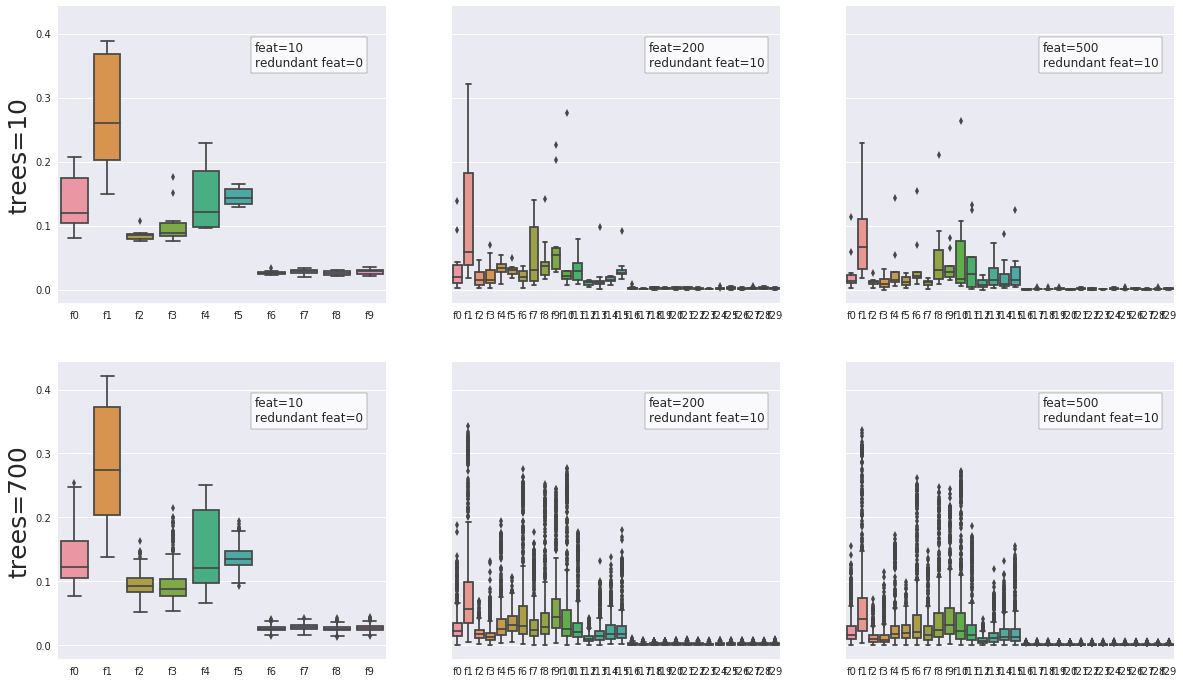

In [19]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, sharey=True, figsize=(20, 12))
axis = [[ax1, ax2, ax3], [ax4, ax5, ax6]]
n_samples=[10000]
n_trees=[10, 700]

rf_test(n_trees, n_samples, True)
for i,n in enumerate(n_trees):
    axis[i][0].set_ylabel('trees={}'.format(n), rotation=90, size=25)

As far as the variance is concerned, in the case with a higher number of trees, the boxplots shows a shorter interquantile range for the relevant features, which indicates a lower variance in the feature importance resulted from the trees of the random forest, however there are a lot more outliers.

It appears that the mean value of the feature importance will be affected as well, but it's difficult to judge from the above boxplots, so lets try to isolate this and measure the improvement in the 2 cases, considering the most difficult case, where the number of features is 500.

In [5]:
# create the sample dataset
X, y = make_classification(n_samples=10000, n_features=500, n_informative=6, n_redundant=10, random_state=0, shuffle=False)

# create and fit the 2 rf classifiers with 10 and 700 trees
rf_small = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=0)
rf_small.fit(X, y)

rf_big = RandomForestClassifier(n_estimators=700, n_jobs=-1, random_state=0)
rf_big.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Text(0,0.5,'Features importance')

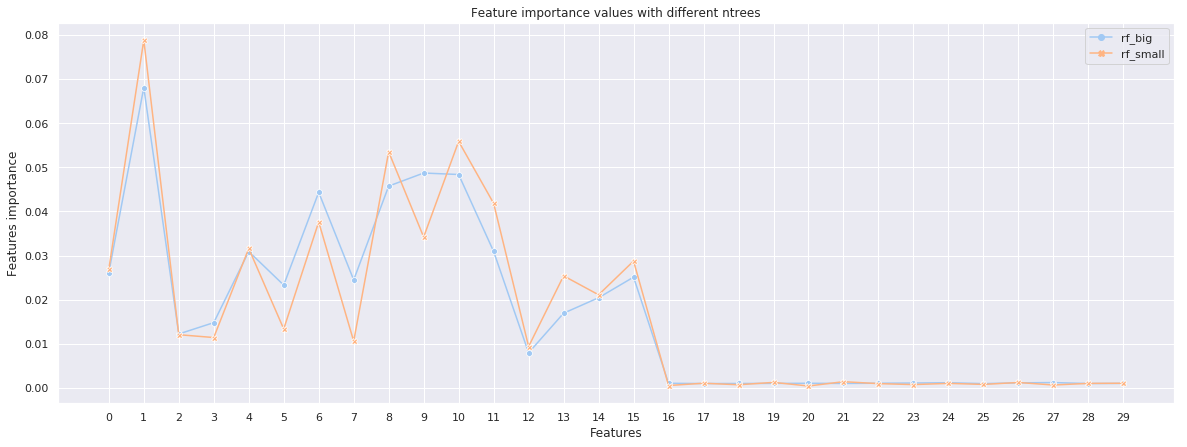

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))

# create the dataframe with the mean feature importance values
data = {
    'rf_small': rf_small.feature_importances_,
    'rf_big': rf_big.feature_importances_
}
df = pd.DataFrame(data=data)

# show only the first 30 features for readability
ax.set_xticks(range(0, 30))
sns.lineplot(data=df.iloc[:30, :], dashes=False, markers=True, ax=ax)
ax.set_title('Feature importance values with different ntrees')
ax.set_xlabel('Features')
ax.set_ylabel('Features importance')

By plotting the value of the feature importances in the 2 examples, with `rf_big` having 700 trees and `rf_small` having only 10 trees it is possible to see that there is not much difference in the importance values. This could be an indication that the number of trees does not significantly affect the goodness of the feature selection process.

One last example that is interesting to analyse is the situation where the number of features is bigger than the number of samples. This is a typical scenario in the medical field.

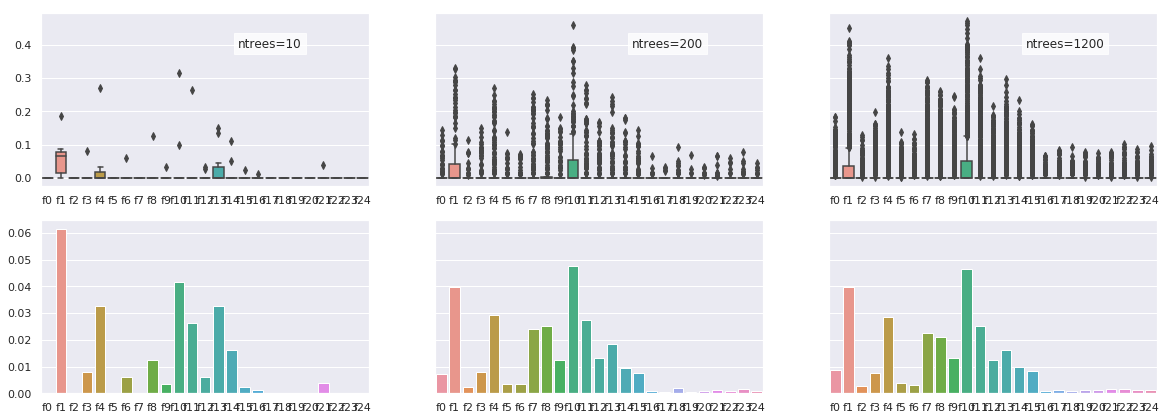

In [29]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, sharey='row', figsize=(20, 7))
axis = [[ax1, ax2, ax3], [ax4, ax5, ax6]]
n_trees=[10, 200, 1200]

# cycle through the number of trees, samples and features
for k, t in enumerate(n_trees):
    # create and fit the rf classificator
    X, y = make_classification(n_samples=250, n_features=500, n_informative=6, n_redundant=10, random_state=0, shuffle=False)
    rf = RandomForestClassifier(n_estimators=t, n_jobs=-1, oob_score=False, random_state=0)
    rf.fit(X, y)
    # name of the features
    col = ['f'+str(i) for i in range(0,500)]
    # retrieve the values of each feature importance of all the trees
    feat_importance = [t.feature_importances_ for t in rf.estimators_]
    df = pd.DataFrame(columns=col, data=feat_importance)
    # limit the max nr of columns to show in the plot
    maxcols=min(df.shape[1], 25)

    # plot
    sns.boxplot(data=df.iloc[:, :maxcols], ax=axis[0][k])
    axis[0][k].set_title('ntrees={}'.format(t))
    #plt.text(0.6, 0.8,'ntrees={}'.format(t), bbox=dict(facecolor='white', alpha=0.8), transform = axis[0][k].transAxes)
    sns.barplot(x=col[:maxcols], y=rf.feature_importances_[:maxcols], ax=axis[1][k])

The above seems a very peculiar and difficult situation, especially when the number of trees is very low. The result improves a lot with an increasing number of trees although it struggles to find high enough significance for some of the features (eg. f2, f5, f6).

## A different approach

A recent study showed that, if predictors are categorical, both Gini index and variable importance approach are biased in favor of variables taking more categories (Strobl et al., 2007).

A very popular and advanced variable importance measure for Random Forests is given by the permutation accuracy
importance (cf. Strobl et al., 2007b). It is determined by the mean difference of prediction accuracies observed for each tree (in terms of correct classification rate or mean squared error (MSE)) before and after random permutation of a predictor variable. Large values indicate a strong association between the predictor variable and the response; as random permutation destroys their original relation and the accuracy is supposed to drop for a relevant predictor. Values around zero (or even small negative values, cf. Strobl et al.,2009) indicate that a predictor is of no predictive value.

To do that one can remove feature from the dataset, re-train the estimator and check the score. Instead of removing a feature one can replace it with random noise - feature column is still there, but it no longer contains useful information. This method works if noise is drawn from the same distribution as original feature values (as otherwise estimator may fail). The simplest way to get such noise is to shuffle values for a feature, i.e. use other examples’ feature values - this is how permutation importance is computed.

The method is most suitable for computing feature importances when a number of columns (features) is not huge.

Lets try to implement this approach, available in the `eli5.sklearn` module, in the following snippets of code.

In [28]:
from eli5.sklearn import PermutationImportance
import timeit

Text(0.5,1,'Random forest + Permutation')

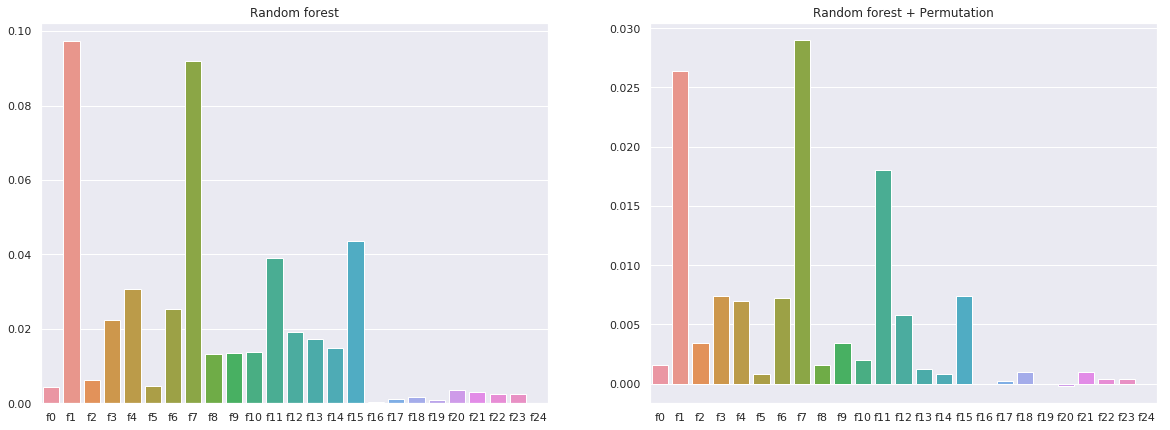

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20, 7))
X, y = make_classification(n_samples=1000, n_features=250, n_informative=6, n_redundant=10, random_state=0, shuffle=False)

start = timeit.default_timer()
rf = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=0)
rf.fit(X, y)
duration1 = timeit.default_timer() - start

start = timeit.default_timer()
perm = PermutationImportance(RandomForestClassifier(n_estimators=10, random_state=0), cv=None)
perm.fit(X, y)
duration2 = timeit.default_timer() - start

col = ['f'+str(i) for i in range(0,250)]
sns.barplot(x=col[:25], y=rf.feature_importances_[:25], ax=ax1)
ax1.set_title('Random forest')
sns.barplot(x=col[:25], y=perm.feature_importances_[:25], ax=ax2)
ax2.set_title('Random forest + Permutation')

In [48]:
print('Standard random forest duration: {}s'.format(round(duration1, 2)))
print('Random forest + permutation duration: {}s'.format(round(duration2, 2)))

Standard random forest duration: 0.11s
Random forest + permutation duration: 2.9s


In this example the 2 approaches seem to deliver the same result but the processing time of the permutation approach is much higher than the standard approach giving no apparent reason to use it in this scenario.

For example, if several features are correlated, and the estimator uses them all equally, permutation importance can be low for all of these features: dropping one of the features may not affect the result, as estimator still has an access to the same information from other features. So if features are dropped based on importance threshold, such correlated features could be dropped all at the same time, regardless of their usefulness. RFE and alike methods (as opposed to single-stage feature selection) can help with this problem to an extent.

In [ ]:
from sklearn.feature_selection import RFE

X, y = make_classification(n_samples=1000, n_features=250, n_informative=6, n_redundant=10, random_state=0, shuffle=False)
rfe = RFE(RandomForestClassifier(n_estimators=10, random_state=0), 5)
rfe.fit(X, y)

s = rfe.ranking_
important_features = sorted(range(len(s)), key=lambda k: s[k])[:15]
print('Most important features: {}'.format(important_features))

Although the importance value of the features is different from the previous methods, using RFE does not help to distinguish the informative features from the redundant ones and delivers the same overall result as the standard random forest and the random forest + permutation approach.

## Real dataset example